<div style="background-color: rgb(235, 218, 30); color: rgb(157, 156, 156); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Data science at Disney World
</div>

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import ipywidgets as widgets
import zipfile
import joblib
import datetime

from IPython.display import display
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


<div style="background-color: rgb(235, 218, 30); color: rgb(157, 156, 156); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Hyperparameters & locations
</div>

In [94]:
locs = {'waiting_folder' : 'data/waiting times'}

<div style="background-color: rgb(235, 218, 30); color: rgb(157, 156, 156); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Step 1: Read in and summarize the data
</div>

Read in all waiting time csv files which are located in data/waiting times. Collect them in one big
dataframe where you add an additional column attraction in which you place the name of the attractions
(which can be taken from the filename).

In [95]:
data_path = 'data/waiting times'
df_list = []

for filename in os.listdir(data_path):
    if filename.endswith('.csv'):
        filepath = os.path.join(data_path, filename)
        attraction_name = filename.replace('.csv', '')
        df = pd.read_csv(filepath)
        df['attraction'] = attraction_name
        df_list.append(df)

all_waiting_times = pd.concat(df_list, ignore_index=True)

all_waiting_times.to_csv('all_waiting_times.csv', index=False)


C:\Users\PC Gebruiker\AppData\Local\Temp\ipykernel_35044\1244178250.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_waiting_times = pd.concat(df_list, ignore_index=True)


<div style="background-color: rgb(235, 218, 30); color: rgb(157, 156, 156); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Data Cleaning
</div>

In [96]:
all_waiting_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10306140 entries, 0 to 10306139
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date        object 
 1   datetime    object 
 2   SACTMIN     float64
 3   SPOSTMIN    float64
 4   attraction  object 
dtypes: float64(2), object(3)
memory usage: 393.1+ MB


In [97]:
df_wait_raw = all_waiting_times.copy()

# 1. Remove outliers in the Actual waiting time
df_wait = df_wait_raw[((df_wait_raw['SACTMIN'] >= -1000) & (df_wait_raw['SACTMIN'] < 360)) | (df_wait_raw['SACTMIN'].isnull())]

# 2. Remove -999 values in the Posted waiting time (closed attraction)
df_wait = df_wait[(df_wait['SPOSTMIN'] >= -998.99) | (df_wait['SPOSTMIN'].isnull())]

# 3. Convert date and time columns to datetime format
df_wait['date'] = pd.to_datetime(df_wait['date'], errors='coerce', format='%m/%d/%Y')
df_wait['datetime'] = pd.to_datetime(df_wait['datetime'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# 4. Print how many rows were removed during cleaning
print(f"Removed {len(df_wait_raw) - len(df_wait)} rows during cleaning")

# 5. Split Actual and Posted waiting time data
df_wait_act = df_wait[~df_wait['SACTMIN'].isnull()].drop('SPOSTMIN', axis=1)
df_wait_post = df_wait[~df_wait['SPOSTMIN'].isnull()].drop('SACTMIN', axis=1)

# 6. Get unique attraction names
attractions = df_wait['attraction'].unique()


Removed 1318703 rows during cleaning


In [98]:
df_wait = df_wait.drop_duplicates()

<div style="background-color: rgb(235, 218, 30); color: rgb(157, 156, 156); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Step 2: Validate the data with some visuals
</div>

Create a function which takes in the dataframe you just created, a date and a list of attractions. The function
should then create a plot in which you have the waiting time over the given date for all selected attractions.
You can use this function to get a feeling for how well filled the actual and posted waiting times are.

In [99]:
df_wait_post.groupby('attraction')['SPOSTMIN'].describe()

,count,mean,std,min,25%,50%,75%,max
attraction,,,,,,,,
7_dwarfs_train,290934.0,76.962455,33.993364,0.0,50.0,70.0,95.0,300.0
alien_saucers,121772.0,29.863351,15.998896,0.0,20.0,30.0,40.0,190.0
astro_orbiter,274923.0,27.026822,13.458805,0.0,20.0,25.0,35.0,180.0
barnstormer,286649.0,19.227069,14.330115,0.0,5.0,15.0,25.0,120.0
big_thunder_mtn,274544.0,37.630817,23.339693,0.0,20.0,35.0,50.0,300.0
buzz_lightyear,296459.0,31.639333,19.493587,0.0,15.0,30.0,45.0,160.0
carousel_of_progress,36096.0,6.333389,3.586248,0.0,5.0,5.0,5.0,80.0
country_bears,10691.0,14.968665,8.613217,0.0,10.0,10.0,20.0,45.0
dinosaur,228624.0,27.399704,19.630231,0.0,10.0,20.0,40.0,300.0


In [100]:
df_wait_act.groupby('attraction')['SACTMIN'].describe()

,count,mean,std,min,25%,50%,75%,max
attraction,,,,,,,,
7_dwarfs_train,7634.0,36.166623,22.950125,0.0,21.0,31.0,46.00,217.0
alien_saucers,3031.0,22.068624,12.586751,0.0,13.0,21.0,30.00,79.0
astro_orbiter,1770.0,20.402260,9.501468,0.0,14.0,20.0,26.00,65.0
barnstormer,3087.0,12.528345,9.900399,0.0,5.0,11.0,18.00,70.0
big_thunder_mtn,11729.0,18.251513,12.913191,0.0,9.0,16.0,25.00,125.0
buzz_lightyear,7998.0,14.120780,12.355926,0.0,5.0,11.0,20.00,109.0
carousel_of_progress,876.0,4.179224,4.455348,0.0,1.0,2.0,6.00,33.0
country_bears,362.0,7.842541,7.213412,0.0,2.0,6.0,11.00,40.0
dinosaur,5059.0,20.197075,15.332370,0.0,8.0,17.0,29.00,96.0


In [101]:
# Create a dropdown widget for selecting attractions
attraction_dropdown = widgets.Dropdown(
    options=attractions,
    description='Attraction:',
    value=attractions[0]  # Default value
)

# Function to update the plot based on selected attraction
def update_plot(attraction):
    plt.figure(figsize=(12, 4))  # Create a new figure
    plt.subplot(1, 2, 1)  # First subplot
    df_wait_attraction = df_wait.query("attraction == @attraction")
    df_wait_attraction.SACTMIN.plot.hist(bins=30, title='Actual waiting times')
    
    plt.subplot(1, 2, 2)  # Second subplot
    df_wait_attraction.SPOSTMIN.plot.hist(bins=np.arange(-2.5, df_wait.SPOSTMIN.max() + 2.5, 10), title='Posted waiting times')
    
    plt.tight_layout()

# Link the dropdown to the update function
interactive_plot = widgets.interactive(update_plot, attraction=attraction_dropdown)

# Display the interactive plot
display(interactive_plot)

interactive(children=(Dropdown(description='Attraction:', options=('7_dwarfs_train', 'alien_saucers', 'astro_o…

C:\Users\PC Gebruiker\AppData\Local\Temp\ipykernel_35044\1575995553.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_a = df.query("attraction == @a and date == @date")
C:\Users\PC Gebruiker\AppData\Local\Temp\ipykernel_35044\1575995553.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_a = df.query("attraction == @a and date == @date")
C:\Users\PC Gebruiker\AppData\Local\Temp\ipykernel_35044\1575995553.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considere

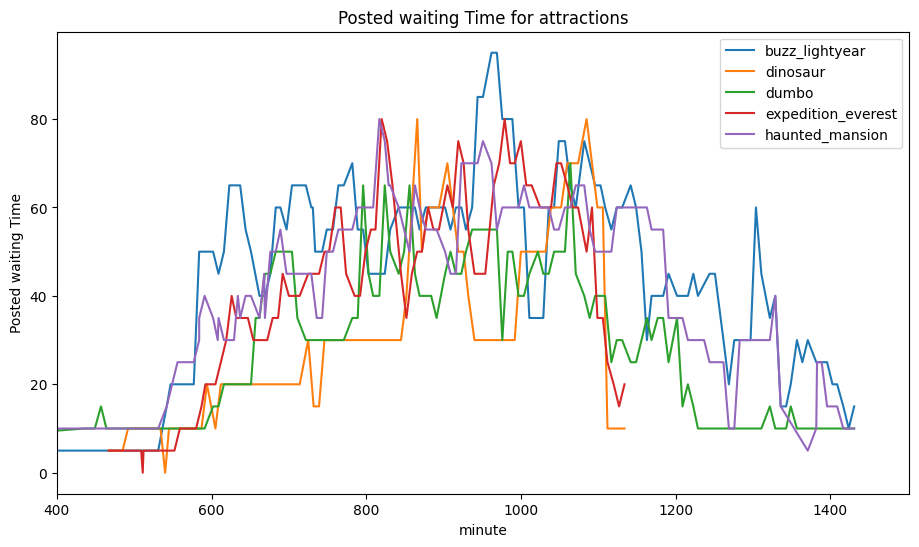

In [102]:
pd.options.mode.chained_assignment = None

def show_posted_waiting(df, date, attractions):
    fig, ax = plt.subplots(figsize=(11,6))
    
    for a in attractions:
        df_a = df.query("attraction == @a and date == @date")
        df_a['minutes'] = df_a['datetime'].dt.hour * 60 + df_a['datetime'].dt.minute
        df_a = df_a.sort_values(by='minutes')
        ax.plot(df_a['minutes'], df_a['SPOSTMIN'], label=a )
        # ax.plot(df_a['datetime'], df_a['SPOSTMIN'], label=a )
    
    ax.legend()
    ax.set_xlim(left=400)
    plt.xlabel('minute')
    plt.ylabel('Posted waiting Time')
    plt.title('Posted waiting Time for attractions')
        

the_attractions = ['buzz_lightyear','dinosaur', 'dumbo', 'expedition_everest', 'haunted_mansion' ]
a_date = '2015-01-01'

show_posted_waiting(df_wait_post, a_date, the_attractions)

In [103]:
df_wait_post['minutes'] = df_wait_post['datetime'].dt.hour * 60 + df_wait_post['datetime'].dt.minute

In [104]:
df_wait_post['weekday'] = df_wait_post['datetime'].dt.day_name()

<div style="background-color: rgb(235, 218, 30); color: rgb(157, 156, 156); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Step 3: Study for which attractions we have sufficient information for posted waiting time.
</div>

Look into how many data points of **posted waiting time** you have per day for each attraction. This way,
you can exclude those attractions with too few data points on average.

In [105]:
posted_counts = df_wait_post.groupby(['attraction', 'date']).size().reset_index(name='count')

In [106]:
avg_counts = posted_counts.groupby('attraction')['count'].mean().sort_values(ascending=False)

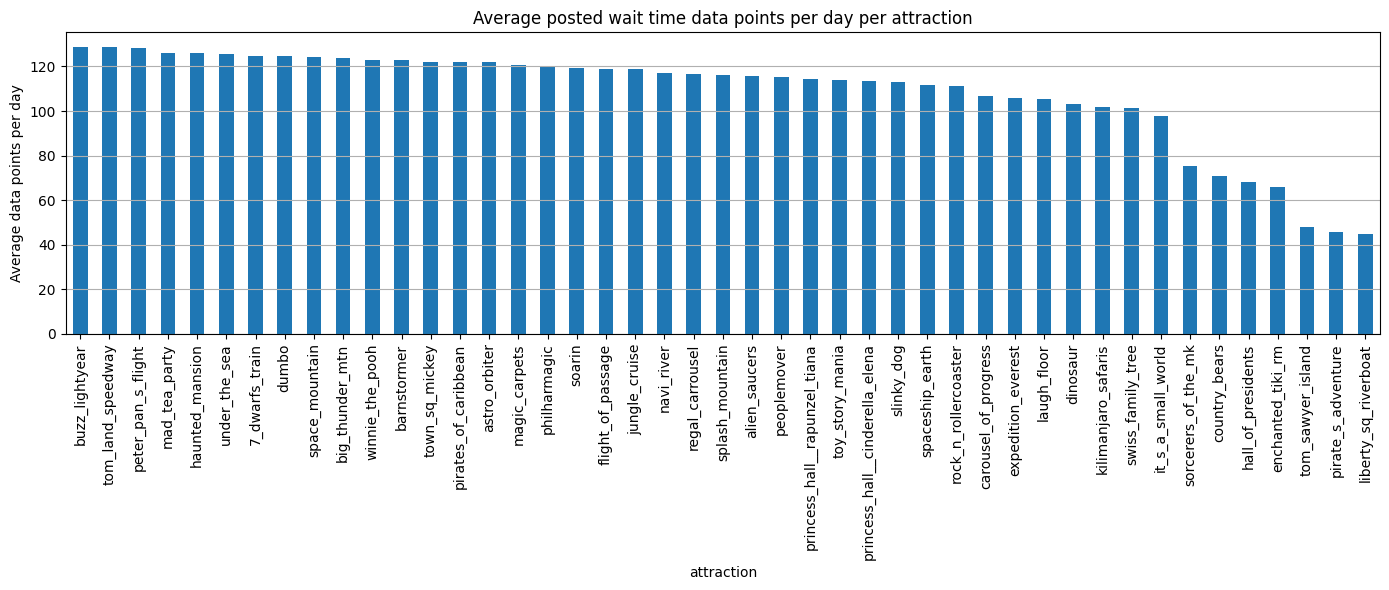

In [107]:
plt.figure(figsize=(14,6))
avg_counts.plot(kind='bar')
plt.ylabel('Average data points per day')
plt.title('Average posted wait time data points per day per attraction')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [108]:
sufficient_attractions = avg_counts[avg_counts >= 10].index.tolist()
print(f"{len(sufficient_attractions)} attractions have sufficient data.")

45 attractions have sufficient data.


In [109]:
df_wait_post_filtered = df_wait_post[df_wait_post['attraction'].isin(sufficient_attractions)]

<div style="background-color: rgb(235, 218, 30); color: rgb(157, 156, 156); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Step 4: Study the distribution of data availability for actual waiting time information
</div>

There seems to be not that much information on the actual waiting times at attractions. Is this because you
simply have limited data each day, or are there some days with a lot of information? Can you make some
visualizations to look into this?

In [110]:
actual_counts_per_day = df_wait_act.groupby('date').size().reset_index(name='count')

In [111]:
actual_counts_per_day.sort_values(by='count', ascending=False).head()


,date,count
2250,2021-10-10,380
2254,2021-10-14,346
2235,2021-09-25,330
2040,2021-03-14,330
2044,2021-03-18,329


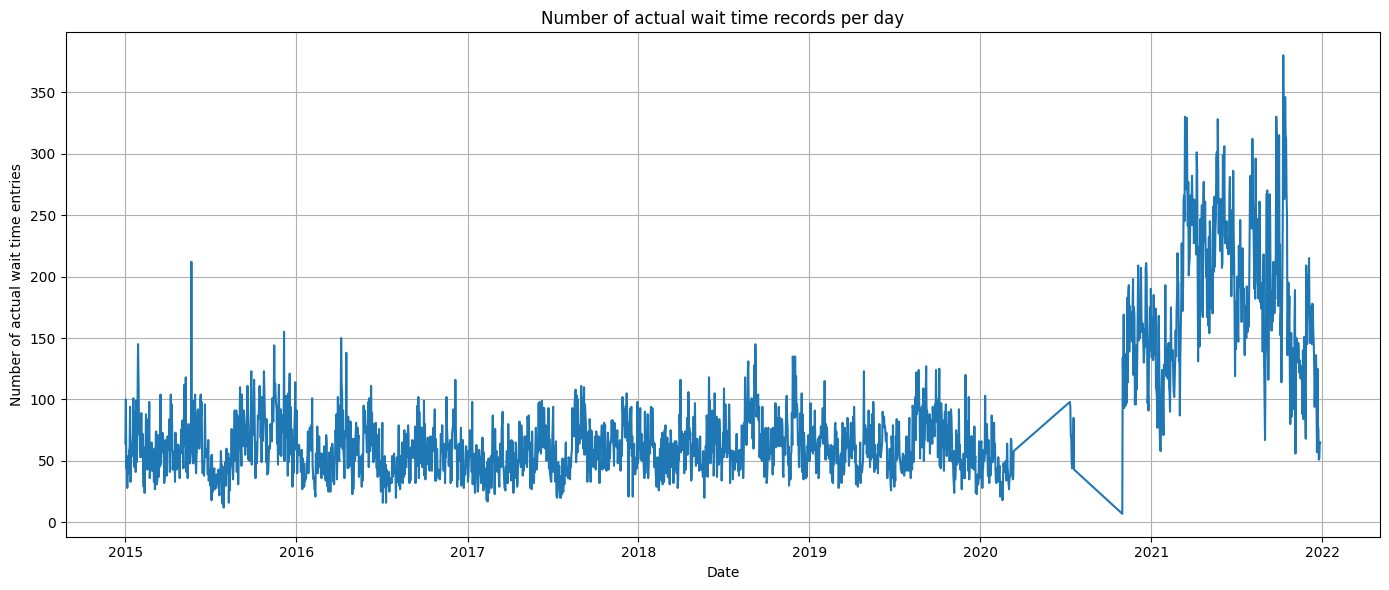

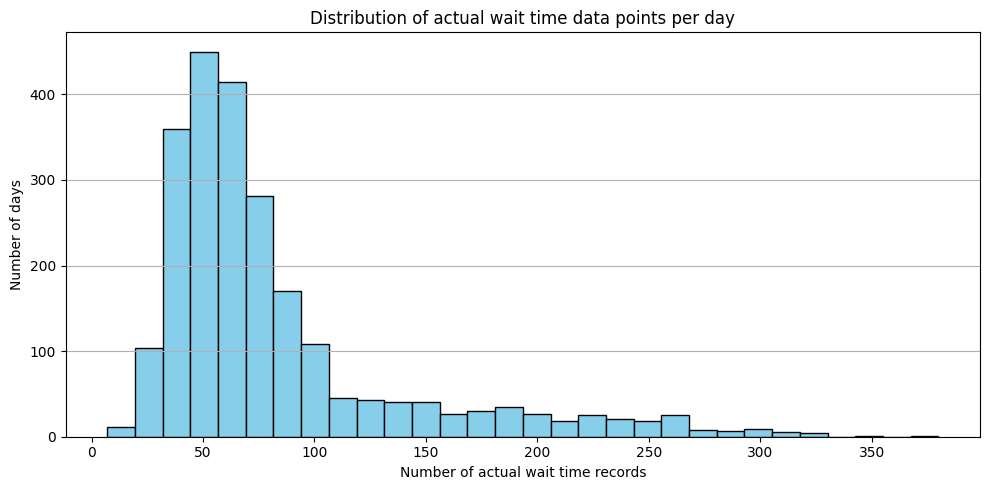

🟢 Days with most actual wait time data:


,date,count
2250,2021-10-10,380
2254,2021-10-14,346
2235,2021-09-25,330
2040,2021-03-14,330
2044,2021-03-18,329


🔴 Days with least actual wait time data:


,date,count
1906,2020-10-31,7
210,2015-07-30,12
208,2015-07-28,15
557,2016-07-11,16
207,2015-07-27,16


In [112]:
# 1. Calculate the number of actual records per day
actual_counts_per_day = df_wait_act.groupby('date').size().reset_index(name='count')

# 2. Display as a time series (how many actual records are there each day?)
plt.figure(figsize=(14,6))
plt.plot(actual_counts_per_day['date'], actual_counts_per_day['count'])
plt.title("Number of actual wait time records per day")
plt.xlabel("Date")
plt.ylabel("Number of actual wait time entries")
plt.grid()
plt.tight_layout()
plt.show()

# 3. Histogram: Distribution of how many records there are per day
plt.figure(figsize=(10,5))
plt.hist(actual_counts_per_day['count'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of actual wait time data points per day")
plt.xlabel("Number of actual wait time records")
plt.ylabel("Number of days")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 4. Days with the most and the fewest records
print("🟢 Days with most actual wait time data:")
display(actual_counts_per_day.sort_values(by='count', ascending=False).head())

print("🔴 Days with least actual wait time data:")
display(actual_counts_per_day.sort_values(by='count').head())


In [113]:
# Subset consisting of actual data only
df_actual = df[~df['SACTMIN'].isnull()].copy()

# Total number of actual records per day
daily_count = df_actual.groupby('date').size().reset_index(name='record_count')

# Number of unique actual values per day
daily_unique_values = df_actual.groupby('date')['SACTMIN'].nunique().reset_index(name='unique_actual_values')

# Merge the two dataframes
daily_actual_analysis = pd.merge(daily_count, daily_unique_values, on='date')

# Convert to datetime format for visualization
daily_actual_analysis['date'] = pd.to_datetime(daily_actual_analysis['date'])

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
print(daily_actual_analysis)

           date  record_count  unique_actual_values
0    2015-01-01             1                     1
1    2016-01-01             2                     1
2    2017-01-01             5                     5
3    2018-01-01             4                     4
4    2020-01-01             2                     2
...         ...           ...                   ...
1843 2016-12-31             1                     1
1844 2017-12-31             1                     1
1845 2018-12-31             1                     1
1846 2019-12-31             1                     1
1847 2020-12-31             9                     8

[1848 rows x 3 columns]


<div style="background-color: rgb(235, 218, 30); color: rgb(157, 156, 156); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Research Question 1: Compare predicted and actual waiting time
</div>

### 🎢 Compare Predicted and Actual Waiting Times

Create a visualization to compare **predicted (posted)** and **actual** waiting times.  
You can follow these steps:

1. 🔄 For each actual waiting time, find the **previous** and **next** posted waiting times.
2. 📈 Use **linear interpolation** to estimate the posted waiting time that corresponds to the actual time.
3. ➖ Calculate the **difference** between actual and posted waiting times.
4. 📊 Create a **histogram** of all these differences.
   - Optionally, use a **scatterplot** or a **2D histogram / heatmap** for more insights.
5. 🔍 Investigate specific **dates** and **attractions** with lots of actual waiting time data.
   - Plot **actual vs. posted waiting times** together in a single visualization for those cases.

In [114]:
top_days = df_actual.groupby(['attraction', 'date']).size().reset_index(name='actual_count')
top_days = top_days.sort_values(by='actual_count', ascending=False)
print(top_days.head(10))

           attraction        date  actual_count
388   winnie_the_pooh  03/14/2021            13
1604  winnie_the_pooh  11/17/2015            12
720   winnie_the_pooh  05/22/2015            12
349   winnie_the_pooh  03/07/2021            12
1635  winnie_the_pooh  11/23/2020            11
1383  winnie_the_pooh  10/01/2021            11
862   winnie_the_pooh  06/18/2021            10
1102  winnie_the_pooh  08/07/2021            10
443   winnie_the_pooh  03/25/2021            10
477   winnie_the_pooh  04/01/2021            10


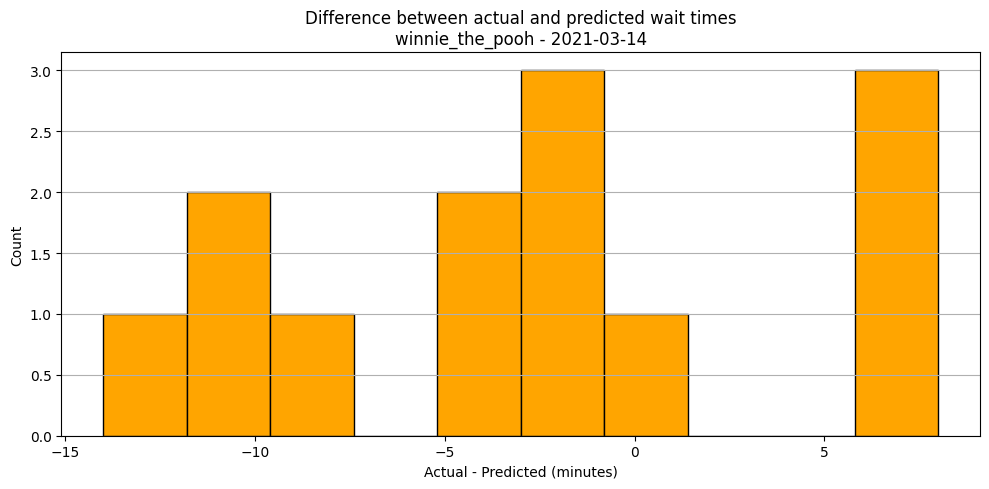

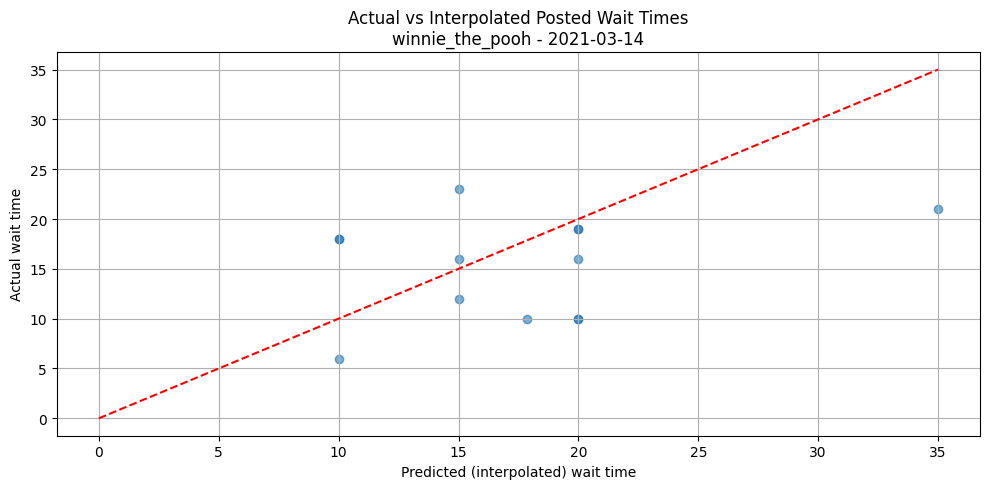

In [115]:
# 1. Select attraction and date
selected_attraction = 'winnie_the_pooh'
selected_date = datetime.date(2021, 3, 14)

# 2. Convert datetime and date columns to proper formats
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['date'] = df['datetime'].dt.date

df_actual['datetime'] = pd.to_datetime(df_actual['datetime'], errors='coerce')
df_actual['date'] = df_actual['datetime'].dt.date

# 3. Filter data for the selected attraction and date
df_actual_sel = df_actual.query("attraction == @selected_attraction and date == @selected_date")
df_posted_sel = df.query("attraction == @selected_attraction and date == @selected_date and not SPOSTMIN.isnull()")

# 4. Sort by time
df_actual_sel = df_actual_sel.sort_values('datetime')
df_posted_sel = df_posted_sel.sort_values('datetime')

# 5. Check if there is enough data
if df_posted_sel.empty or df_actual_sel.empty:
    print("⚠️ Not enough actual or posted data for the selected date and attraction.")
else:
    # 6. Convert datetime to UNIX timestamp (seconds)
    df_posted_sel['timestamp'] = df_posted_sel['datetime'].astype(np.int64) // 10**9
    df_actual_sel['timestamp'] = df_actual_sel['datetime'].astype(np.int64) // 10**9

    # 7. Linear interpolation of posted wait times at actual timestamps
    interp_posted = np.interp(
        df_actual_sel['timestamp'],
        df_posted_sel['timestamp'],
        df_posted_sel['SPOSTMIN']
    )

    # 8. Calculate differences
    df_actual_sel['interpolated_posted'] = interp_posted
    df_actual_sel['difference'] = df_actual_sel['SACTMIN'] - df_actual_sel['interpolated_posted']

    # 9. Plot histogram of differences
    plt.figure(figsize=(10,5))
    plt.hist(df_actual_sel['difference'], bins=10, color='orange', edgecolor='black')
    plt.title(f'Difference between actual and predicted wait times\n{selected_attraction} - {selected_date}')
    plt.xlabel('Actual - Predicted (minutes)')
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # 10. Scatter plot of actual vs predicted
    plt.figure(figsize=(10,5))
    plt.scatter(df_actual_sel['interpolated_posted'], df_actual_sel['SACTMIN'], alpha=0.6)
    plt.plot(
        [0, max(df_actual_sel['interpolated_posted'])],
        [0, max(df_actual_sel['interpolated_posted'])],
        color='red', linestyle='--'
    )
    plt.title(f'Actual vs Interpolated Posted Wait Times\n{selected_attraction} - {selected_date}')
    plt.xlabel('Predicted (interpolated) wait time')
    plt.ylabel('Actual wait time')
    plt.grid()
    plt.tight_layout()
    plt.show()


In [116]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['date'] = df['datetime'].dt.date
df_actual['datetime'] = pd.to_datetime(df_actual['datetime'], errors='coerce')
df_actual['date'] = df_actual['datetime'].dt.date

In [117]:
df_actual_sel[['datetime', 'SACTMIN', 'interpolated_posted', 'difference']].head(10)

,datetime,SACTMIN,interpolated_posted,difference
267236,2021-03-14 10:30:57,18.0,10.000000,8.000000
267237,2021-03-14 10:32:29,18.0,10.000000,8.000000
267243,2021-03-14 11:06:40,16.0,20.000000,-4.000000
267262,2021-03-14 13:14:34,10.0,17.869081,-7.869081
267267,2021-03-14 13:40:41,21.0,35.000000,-14.000000
267290,2021-03-14 16:01:26,19.0,20.000000,-1.000000
267292,2021-03-14 16:07:27,19.0,20.000000,-1.000000
267303,2021-03-14 17:04:03,12.0,15.000000,-3.000000
267304,2021-03-14 17:08:49,23.0,15.000000,8.000000
267314,2021-03-14 18:10:42,16.0,15.000000,1.000000


In [118]:
print(f"Actual count: {len(df_actual_sel)}")
print(f"Interpolated posted count: {len(df_actual_sel['interpolated_posted'])}")
print(f"Min difference: {df_actual_sel['difference'].min()}, Max difference: {df_actual_sel['difference'].max()}")


Actual count: 13
Interpolated posted count: 13
Min difference: -14.0, Max difference: 8.0


In [119]:
print("Average difference:", df_actual_sel['difference'].mean())

Average difference: -2.297621598457253


<div style="background-color: rgb(235, 218, 30); color: rgb(157, 156, 156); font-size: 24px; font-weight: bold; padding: 10px; border-radius: 15px;">
    Research Question 2: best day for rides
</div>

### 🎠 Analyzing Wait Times for Ride Attractions

1. **Filter** the dataset to include only attractions where `category_code == 'ride'`.

2. **Determine** which **day of the week** (Monday, Tuesday, ...) has the **lowest average posted waiting time** for these rides.

3. In a **second step**, analyze the **combination of day of the week and `HOLIDAYM` value** to see how holidays affect waiting times on different days.

---

### 📘 What Does This Mean?

- By identifying the day with the **shortest average posted wait times**, park operations can better manage ride schedules and maintenance.
- The `HOLIDAYM` variable indicates whether a date is a **holiday** or **non-holiday**.  
  Combining this with the day of the week helps us understand whether holidays significantly impact wait times on specific days (e.g., **Saturdays on holidays vs. regular Saturdays**).


**Step 1**

In [120]:
entities_extra = pd.read_csv("C:/Disney_Waiting_Times/disney-waiting-times/data/overview data/entities_extra.csv")

In [121]:
# 1. Convert short_name to snake_case format
entities_extra['short_name_snake'] = (
    entities_extra['short_name']
    .str.lower()
    .str.replace(' ', '_')
    .str.replace("'", "")
    .str.replace("&", "and")
    .str.replace("-", "_")
    .str.replace("__", "_")
    .str.strip()
)

# 2. Get the names of attractions that are classified as rides
ride_names = entities_extra[entities_extra['category_code'] == 'ride']['short_name_snake'].dropna().unique()

# 3. Load the waiting time data
df = pd.read_csv("C:/Disney_Waiting_Times/disney-waiting-times/all_waiting_times_extracted/all_waiting_times.csv")
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['weekday'] = df['datetime'].dt.day_name()

# 4. Filter only rides and clean data (positive, reasonable wait times only)
df_rides = df[
    df['attraction'].isin(ride_names) &
    df['SPOSTMIN'].notna() &
    (df['SPOSTMIN'] >= 0) &
    (df['SPOSTMIN'] < 300)  # Exclude extremely high values (over 5 hours)
].copy()

# 5. Calculate the average posted wait time per day of the week
avg_wait_by_day = df_rides.groupby('weekday')['SPOSTMIN'].mean().sort_values()

# 6. Print the results
print("✅ Cleaned Average Posted Wait Time by Weekday:")
print(avg_wait_by_day)


✅ Cleaned Average Posted Wait Time by Weekday:
weekday
Thursday     28.619694
Sunday       28.620102
Friday       28.785998
Tuesday      30.141389
Wednesday    31.648925
Monday       33.207759
Saturday     33.987218
Name: SPOSTMIN, dtype: float64


C:\Users\PC Gebruiker\AppData\Local\Temp\ipykernel_35044\2785279251.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
C:\Users\PC Gebruiker\AppData\Local\Temp\ipykernel_35044\2785279251.py:28: UserWarning: Glyph 127906 (\N{ROLLER COASTER}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\PC Gebruiker\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127906 (\N{ROLLER COASTER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


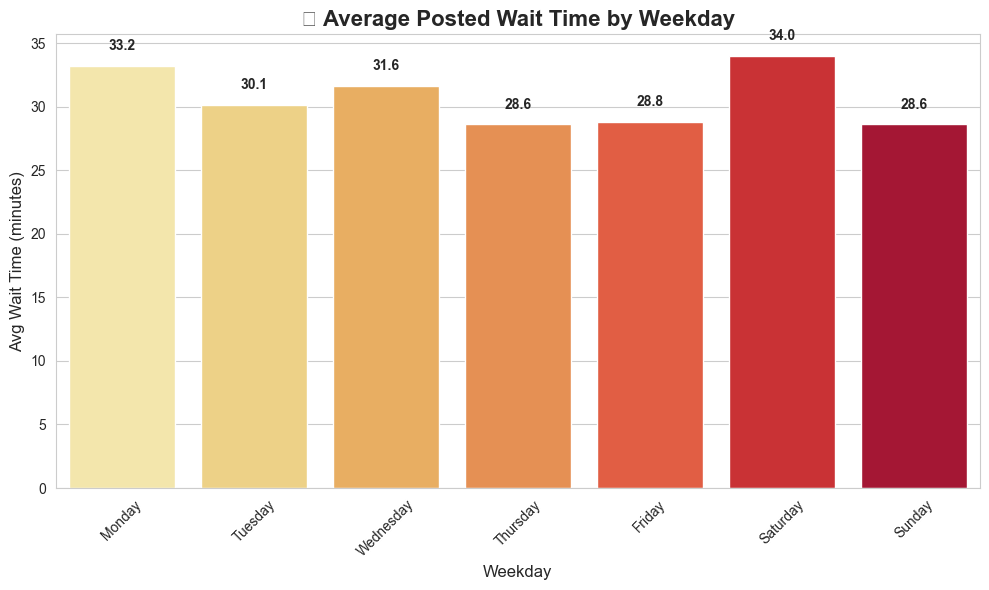

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare sorted average wait time by weekday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_wait_by_day = df_rides.groupby('weekday')['SPOSTMIN'].mean().reindex(weekday_order)

# Step 2: Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
palette = sns.color_palette("YlOrRd", len(avg_wait_by_day))

barplot = sns.barplot(
    x=avg_wait_by_day.index,
    y=avg_wait_by_day.values,
    palette=palette
)

# Step 3: Annotate each bar with value
for index, value in enumerate(avg_wait_by_day.values):
    barplot.text(index, value + 1, f"{value:.1f}", ha='center', va='bottom', fontweight='bold')

# Step 4: Customize
plt.title("🎢 Average Posted Wait Time by Weekday", fontsize=16, fontweight='bold')
plt.xlabel("Weekday", fontsize=12)
plt.ylabel("Avg Wait Time (minutes)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Step 2**

In [122]:
metadata = pd.read_csv("C:/Disney_Waiting_Times/disney-waiting-times/data/overview data/metadata.csv")

In [ ]:
# Create HOLIDAYN → Holiday Name mapping
holiday_code_to_name = {
    "ash": "Ash Wednesday", "cdm": "Cinco De Mayo", "chv": "Cesar Chavez Day",
    "cmd": "Christmas Day", "cme": "Christmas Eve", "col": "Columbus Day",
    "elc": "Election Day", "esm": "Easter Monday", "ess": "Easter Sunday",
    "fat": "Father's Day", "gfr": "Good Friday", "hal": "Halloween",
    "han": "Hanukkah", "ind": "Independence Day", "lab": "Labor Day",
    "mem": "Memorial Day", "mgs": "Mardi Gras", "mlk": "Martin Luther King Jr. Day",
    "mot": "Mother's Day", "njc": "NJEA Convention", "nvd": "Nevada Day",
    "nyd": "New Year's Day", "nye": "New Year's Eve", "pas": "Passover",
    "prs": "Presidents Day", "pur": "Purim", "rha": "Rosh Hashanah",
    "sbs": "Super Bowl Sunday", "sha": "Shemini Atzeret", "stp": "St. Patrick's Day",
    "suk": "Sukkot", "svt": "Shavuot", "thk": "Thanksgiving",
    "utc": "Utah Educators Day", "val": "Valentine's Day",
    "vet": "Veterans Day", "ymk": "Yom Kippur"
}

In [124]:
# Convert date column in both dataframes to datetime (if needed)
df_rides['date'] = pd.to_datetime(df_rides['datetime']).dt.date
metadata['DATE'] = pd.to_datetime(metadata['DATE']).dt.date

In [126]:
# Fill missing holidays BEFORE the merge
df_rides['date'] = pd.to_datetime(df_rides['datetime']).dt.date
metadata['DATE'] = pd.to_datetime(metadata['DATE']).dt.date

# Merge HOLIDAYM info
df_rides = df_rides.merge(metadata[['DATE', 'HOLIDAYM', 'HOLIDAYN']], left_on='date', right_on='DATE', how='left')

# Map holiday codes to names
df_rides['Holiday_Name'] = df_rides['HOLIDAYN'].map(holiday_code_to_name)

# Fill missing HOLIDAYM with 0 and missing names with "None"
df_rides['HOLIDAYM'] = df_rides['HOLIDAYM'].fillna(0)
df_rides['Holiday_Name'] = df_rides['Holiday_Name'].fillna("None")

In [127]:
# Group by weekday and Holiday Name
avg_wait_by_combo = df_rides.groupby(['weekday', 'Holiday_Name'])['SPOSTMIN'].mean().unstack()

# Show result
print("🎉 Average Posted Wait Time by Weekday + Holiday:")
print(avg_wait_by_combo)

🎉 Average Posted Wait Time by Weekday + Holiday:
Holiday_Name  Ash Wednesday  Cesar Chavez Day  Christmas Day  Christmas Eve  \
weekday                                                                       
Friday                  NaN         36.046163      32.847796            NaN   
Monday                  NaN         43.997038      56.566574      53.756793   
Saturday                NaN               NaN            NaN      35.641554   
Sunday                  NaN         39.077519            NaN      45.875803   
Thursday                NaN         39.678796            NaN      31.994433   
Tuesday                 NaN         35.630841      56.928328      56.543242   
Wednesday         35.416954               NaN      56.341043            NaN   

Holiday_Name  Cinco De Mayo  Columbus Day  Easter Monday  Easter Sunday  \
weekday                                                                   
Friday            32.395151           NaN            NaN            NaN   
Monday        

In [130]:
df_rides.groupby(['weekday', 'Holiday_Name'])['SPOSTMIN'].mean().unstack()

Holiday_Name,Ash Wednesday,Cesar Chavez Day,Christmas Day,Christmas Eve,Cinco De Mayo,Columbus Day,Easter Monday,Easter Sunday,Election Day,Father's Day,Good Friday,Halloween,Hanukkah,Independence Day,Labor Day,Mardi Gras,Martin Luther King Jr. Day,Memorial Day,Mother's Day,NJEA Convention,Nevada Day,New Year's Day,New Year's Eve,None,Passover,Presidents Day,Purim,Rosh Hashanah,Shavuot,Shemini Atzeret,St. Patrick's Day,Sukkot,Super Bowl Sunday,Thanksgiving,Utah Educators Day,Valentine's Day,Veterans Day,Yom Kippur
weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Friday,NaN,36.046163,32.847796,NaN,32.395151,NaN,NaN,NaN,NaN,NaN,35.873236,NaN,30.346926,NaN,NaN,NaN,NaN,NaN,NaN,25.481240,21.910979,30.733504,NaN,28.724119,NaN,NaN,NaN,NaN,NaN,NaN,45.437302,NaN,NaN,NaN,23.792866,43.052575,NaN,NaN
Monday,NaN,43.997038,56.566574,53.756793,NaN,26.329181,39.848094,NaN,NaN,NaN,NaN,18.559219,33.530746,31.931818,19.743477,NaN,33.495333,28.747147,NaN,NaN,NaN,22.691130,59.968906,33.235056,NaN,39.481889,NaN,28.890622,NaN,28.202744,NaN,29.916963,NaN,NaN,NaN,NaN,28.831776,NaN
Saturday,NaN,NaN,NaN,35.641554,30.380906,NaN,NaN,NaN,NaN,NaN,NaN,18.551944,NaN,33.821155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.691340,33.873833,35.660050,NaN,NaN,NaN,NaN,NaN,38.959314,NaN,NaN,NaN,NaN,41.343343,46.861727,31.285925
Sunday,NaN,39.077519,NaN,45.875803,34.527962,NaN,NaN,32.587248,NaN,24.722294,NaN,NaN,NaN,25.213368,NaN,NaN,NaN,NaN,25.612087,NaN,NaN,30.395869,58.481188,28.229260,NaN,NaN,34.890194,NaN,29.789467,NaN,38.388260,NaN,30.787205,NaN,NaN,38.726487,41.191478,NaN
Thursday,NaN,39.678796,NaN,31.994433,33.930523,NaN,NaN,NaN,NaN,NaN,NaN,16.659226,NaN,41.525382,NaN,NaN,NaN,NaN,NaN,23.560879,NaN,44.431006,38.552978,28.344133,NaN,NaN,35.563886,34.152160,NaN,22.545183,36.267692,16.302959,NaN,37.821098,20.919045,33.417508,NaN,NaN
Tuesday,NaN,35.630841,56.928328,56.543242,24.295296,NaN,NaN,NaN,29.149355,NaN,NaN,19.241415,NaN,46.230451,NaN,35.970628,NaN,NaN,NaN,NaN,NaN,37.288715,64.637517,29.602169,42.930698,NaN,42.844037,NaN,NaN,NaN,31.123088,NaN,NaN,NaN,NaN,27.088745,NaN,NaN
Wednesday,35.416954,NaN,56.341043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.175702,39.904671,43.182904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.235049,NaN,31.408278,NaN,NaN,NaN,NaN,37.800257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.486739,34.117312


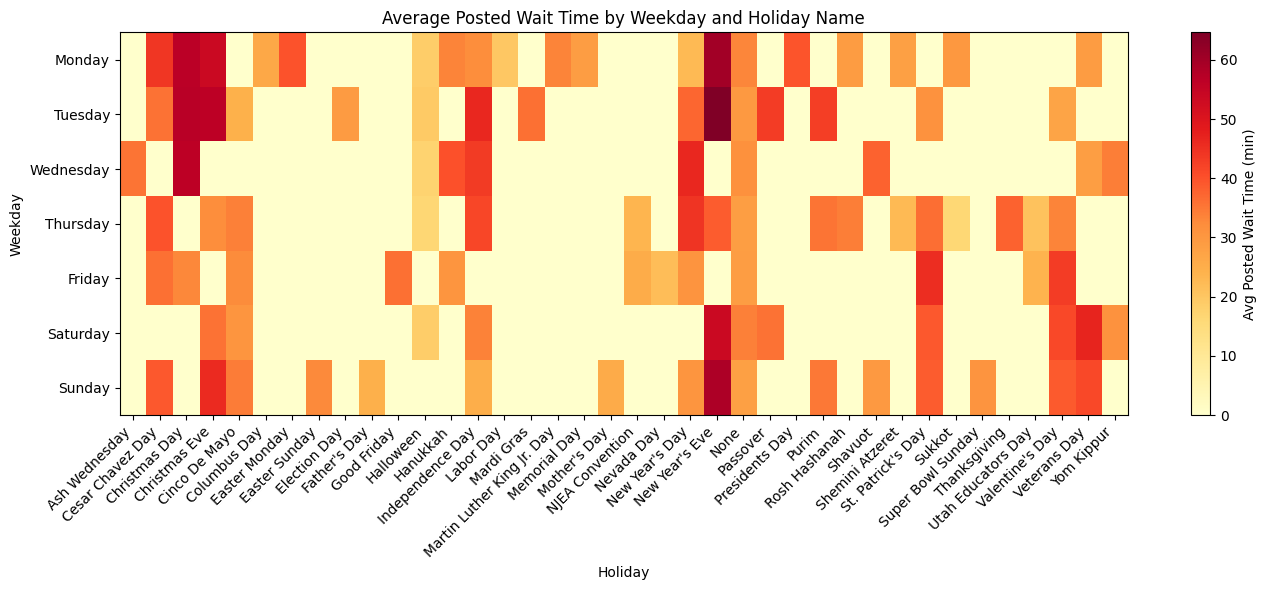

In [131]:
import matplotlib.pyplot as plt

# Reorder weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group data using Holiday_Name
heatmap_data = df_rides.groupby(['weekday', 'Holiday_Name'])['SPOSTMIN'].mean().unstack(fill_value=0)
heatmap_data = heatmap_data.reindex(weekday_order)

# Plot heatmap
plt.figure(figsize=(14, 6))
plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Avg Posted Wait Time (min)')

# Set axis labels
plt.xticks(ticks=range(len(heatmap_data.columns)), labels=heatmap_data.columns, rotation=45, ha='right')
plt.yticks(ticks=range(len(heatmap_data.index)), labels=heatmap_data.index)

plt.title('Average Posted Wait Time by Weekday and Holiday Name')
plt.xlabel('Holiday')
plt.ylabel('Weekday')
plt.tight_layout()
plt.show()

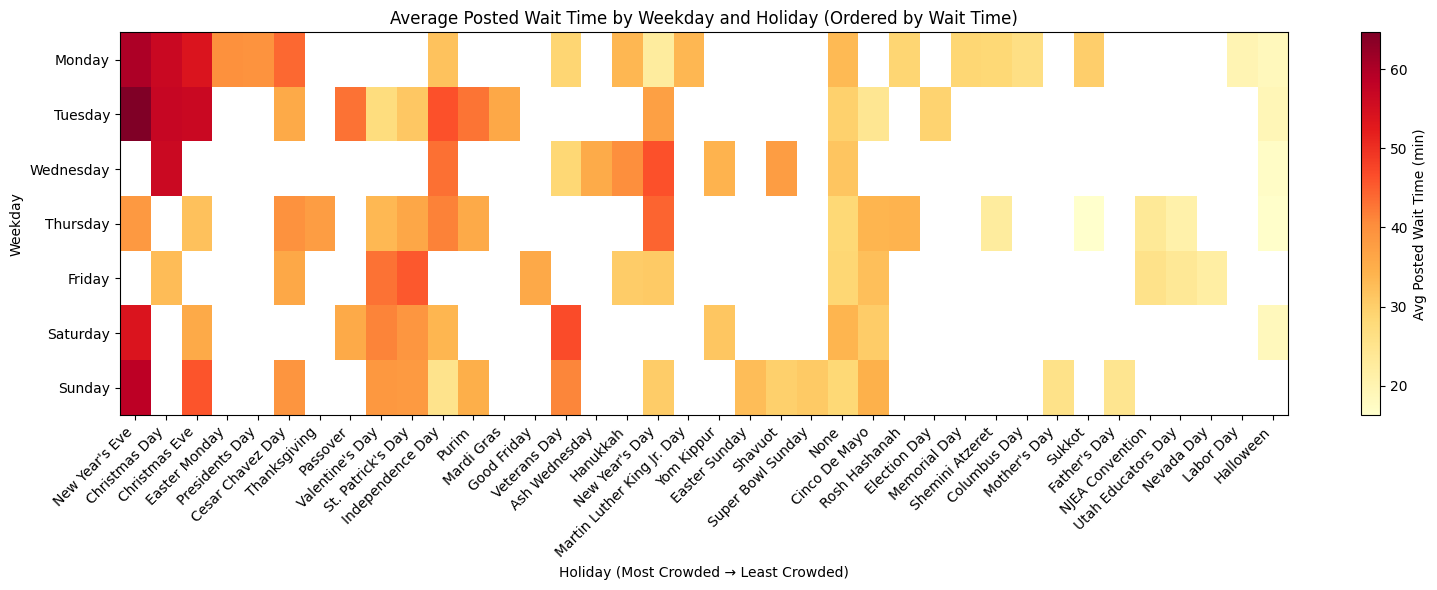

In [135]:

# 1. Fixed weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 2. Heatmap data: average wait time grouped by weekday and holiday name
heatmap_data = df_rides.groupby(['weekday', 'Holiday_Name'])['SPOSTMIN'].mean().unstack()

# 3. Sort holidays by average wait time (descending)
holiday_order = df_rides.groupby('Holiday_Name')['SPOSTMIN'].mean().sort_values(ascending=False).index.tolist()

# 4. Reorder the heatmap data
heatmap_data = heatmap_data.reindex(index=weekday_order, columns=holiday_order)

# 5. Visualization
plt.figure(figsize=(16, 6))
plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Avg Posted Wait Time (min)')

plt.xticks(ticks=range(len(heatmap_data.columns)), labels=heatmap_data.columns, rotation=45, ha='right')
plt.yticks(ticks=range(len(heatmap_data.index)), labels=heatmap_data.index)

plt.title('Average Posted Wait Time by Weekday and Holiday (Ordered by Wait Time)')
plt.xlabel('Holiday (Most Crowded → Least Crowded)')
plt.ylabel('Weekday')
plt.tight_layout()
plt.show()

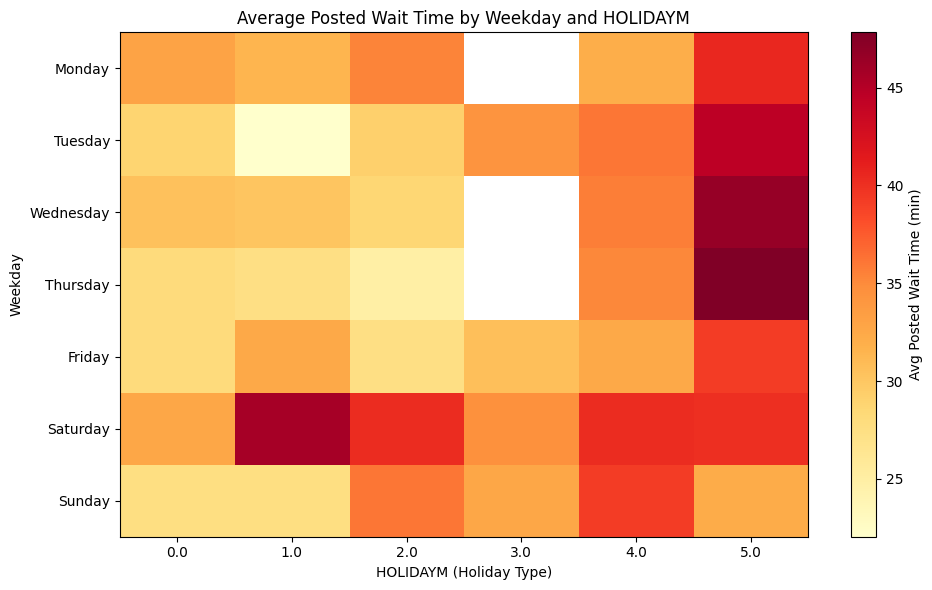

In [ ]:
import matplotlib.pyplot as plt

# Group the data
heatmap_data = df_rides.groupby(['weekday', 'HOLIDAYM'])['SPOSTMIN'].mean().unstack()

# Reorder weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(weekday_order)

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Avg Posted Wait Time (min)')

# Set labels
plt.xticks(ticks=range(len(heatmap_data.columns)), labels=heatmap_data.columns)
plt.yticks(ticks=range(len(heatmap_data.index)), labels=heatmap_data.index)

plt.title('Average Posted Wait Time by Weekday and HOLIDAYM')
plt.xlabel('HOLIDAYM (Holiday Type)')
plt.ylabel('Weekday')
plt.tight_layout()
plt.show()